In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import lightgbm as lgb
import xgboost as xgb
import torch
import pickle

In [4]:
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [200]:
df = pd.read_csv('./data/train.csv',engine='python')
test_df = pd.read_csv('./data/test.csv',engine='python')

In [201]:
def processing(dt):
    dt['Date(MM/DD/YYYY)']= pd.to_datetime(dt['Date(MM/DD/YYYY)'])
    dt = dt.assign(
        Month=  dt['Date(MM/DD/YYYY)'].dt.month,
        Day = dt['Date(MM/DD/YYYY)'].dt.day,
        Year =dt['Date(MM/DD/YYYY)'].dt.year,
                  )
    dt.drop('Date(MM/DD/YYYY)', axis=1, inplace=True)
    
    dt.loc[dt['Solar Radiance(w/m^2)']<0,'Solar Radiance(w/m^2)'] = 0
    mean_t, mean_s = dt.loc[(df['Month']==2)&(df['Temperature(C)']!=-99999.0 ),['Temperature(C)','Solar Power(kW)']].mean()
    dt.loc[df['Temperature(C)']==-99999.0, ['Temperature(C)','Solar Power(kW)']] = (mean_t, mean_s)
    
    return dt

In [202]:
df = processing(df)
test_df = processing(test_df)

In [ ]:
train_id = df.loc[df['Temperature(C)'].isnull()].index
id = test_df.loc[test_df['Temperature(C)'].isnull()].index

In [205]:
df.describe()

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Month,Day,Year
count,105120.000000,103272.000000,103249.000000,103249.000000,105120.000000,105120.000000,105120.000000
mean,11.500000,236.417396,22.118662,58.609162,6.526027,15.720548,2014.083333
std,6.922219,317.933331,10.057998,78.089369,3.447868,8.796289,3.882851
min,0.000000,0.000000,-2.121600,0.000000,1.000000,1.000000,2008.000000
25%,5.750000,0.000000,13.647300,0.000000,4.000000,8.000000,2010.750000
50%,11.500000,10.191550,21.705000,2.578180,7.000000,16.000000,2014.500000
75%,17.250000,466.469025,30.480300,118.465525,10.000000,23.000000,2017.250000
max,23.000000,1154.582000,46.144500,297.681980,12.000000,31.000000,2020.000000


<AxesSubplot:>

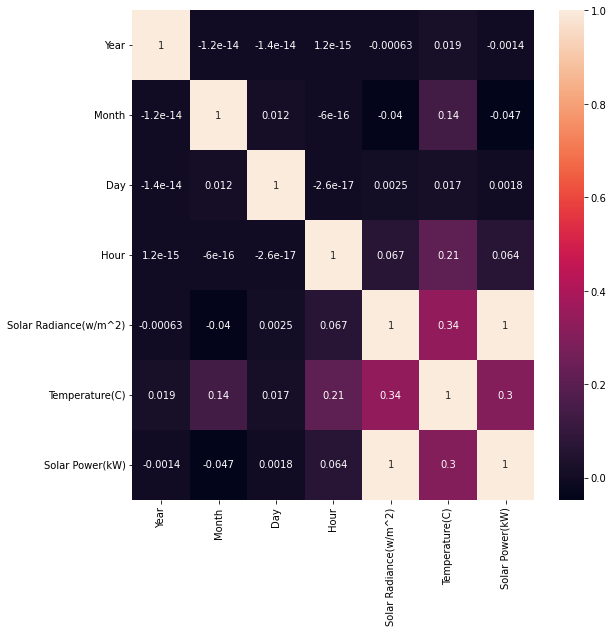

In [206]:
feature = ['Year','Month','Day','Hour','Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)']
train_co = df[feature]
train_co
# print(train_co.corr())
train_co.corr()
plt.figure(figsize=(9,9))
sns.heatmap(train_co.corr(), annot=True)
# plt.figure(figsize=(9,9))
# sns.heatmap(test_df.corr(), annot=True)

In [207]:
train = df[:87600]
val = df[87600:96360]

In [208]:
train = train.fillna(method='ffill')

In [324]:
features = ['Month','Day','Hour']
train_x = train[features]
train_y = train['Temperature(C)']

val_x = val[features]
val_y = val['Temperature(C)']

In [175]:
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'metric':'mse', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 1000, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[03:05:30] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:23.66485	eval-rmse:22.83846
[20]	train-rmse:19.48573	eval-rmse:18.67617
[40]	train-rmse:16.09244	eval-rmse:15.30403
[60]	train-rmse:13.34582	eval-rmse:12.58516
[80]	train-rmse:11.13213	eval-rmse:10.40717
[100]	train-rmse:9.35977	eval-rmse:8.68039
[120]	train-rmse:7.94970	eval-rmse:7.32217
[140]	train-rmse:6.84158	eval-rmse:6.27829
[160]	train-rmse:5.98261	eval-rmse:5.49776
[180]	train-rmse:5.32282	eval-rmse:4.92486
[200]	train-rmse:4.81653	eval-rmse:4.51708
[220]	train-rmse:4.44366	eval-rmse:4.24219
[240]	train-rmse:4.17141	eval-rmse:4.06317
[260]	train-rmse:3.97605	eval-rmse:3.95580
[280]	train-rmse:3.83678	eval-rmse:3.

In [259]:
test = df[96360:]
test.describe()

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Month,Day,Year
count,8760.000000,6912.000000,6912.000000,6912.000000,8760.000000,8760.000000,8760.0
mean,11.500000,238.308595,22.134330,59.020715,6.526027,15.720548,2020.0
std,6.922582,317.514732,10.620961,77.824192,3.448048,8.796749,0.0
min,0.000000,0.000000,1.805400,0.000000,1.000000,1.000000,2020.0
25%,5.750000,0.000000,12.808525,0.000000,4.000000,8.000000,2020.0
50%,11.500000,9.755750,20.855550,2.427515,7.000000,16.000000,2020.0
75%,17.250000,477.700650,31.411175,121.124963,10.000000,23.000000,2020.0
max,23.000000,1084.883200,45.179000,274.091265,12.000000,31.000000,2020.0


In [170]:
#test = test.fillna(method='ffill')

In [214]:
#test.loc[test2['Temperature(C)'].isnull()]

,Hour,Solar Radiance(w/m^2),Temperature(C),Solar Power(kW),Month,Day,Year
97104,0,NaN,NaN,NaN,2,1,2020
97105,1,NaN,NaN,NaN,2,1,2020
97106,2,NaN,NaN,NaN,2,1,2020
97107,3,NaN,NaN,NaN,2,1,2020
97108,4,NaN,NaN,NaN,2,1,2020
...,...,...,...,...,...,...,...
104539,19,NaN,NaN,NaN,12,7,2020
104540,20,NaN,NaN,NaN,12,7,2020
104541,21,NaN,NaN,NaN,12,7,2020
104542,22,NaN,NaN,NaN,12,7,2020


In [261]:
features = ['Month','Day','Hour']
test_x = test[features]
test_x = xgb.DMatrix(test_x)
preds = model.predict(test_x)

In [262]:
test['Temperature(C)'] = preds

/tmp/ipykernel_59052/947860230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Temperature(C)'] = preds


In [210]:
features = ['Hour','Temperature(C)']
train_x = train[features]
train_y = train['Solar Power(kW)']

val_x = val[features]
val_y = val['Solar Power(kW)']

In [211]:
dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'metric':'mse', 
    'seed':42
}
 

model2 = xgb.train( params, dtrain, 1000, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[03:26:12] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:96.47141	eval-rmse:96.10995
[20]	train-rmse:80.33850	eval-rmse:80.29485
[40]	train-rmse:67.38644	eval-rmse:67.60521
[60]	train-rmse:57.08244	eval-rmse:57.50268
[80]	train-rmse:48.95810	eval-rmse:49.52484
[100]	train-rmse:42.64355	eval-rmse:43.32147
[120]	train-rmse:37.80269	eval-rmse:38.56178
[140]	train-rmse:34.16946	eval-rmse:34.96696
[160]	train-rmse:31.48556	eval-rmse:32.29095
[180]	train-rmse:29.54206	eval-rmse:30.32572
[200]	train-rmse:28.15202	eval-rmse:28.89903
[220]	train-rmse:27.17075	eval-rmse:27.87473
[240]	train-rmse:26.48165	eval-rmse:27.13762
[260]	train-rmse:26.00168	eval-rmse:26.61550
[280]	train-rmse:25

In [329]:
Pkl_Filename = "./model/Solar_Power_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model2, file)

In [301]:
features = ['Hour','Temperature(C)']
test_x = test[features]
test_x = xgb.DMatrix(test_x)
preds = model2.predict(test_x)

In [302]:
test.loc[:,'Solar Power(kW)'] = preds

In [303]:
test.loc[test['Solar Power(kW)']<0.1,'Solar Power(kW)'] = 0

In [230]:
features = ['Solar Power(kW)']
train_x = train[features]
train_y = train['Solar Radiance(w/m^2)']

val_x = val[features]
val_y = val['Solar Radiance(w/m^2)']

In [231]:
dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'metric':'mse',
    'seed':42
}
 

model3 = xgb.train( params, dtrain, 1000, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[04:21:43] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:392.16934	eval-rmse:389.15649
[20]	train-rmse:320.97449	eval-rmse:318.16544
[40]	train-rmse:262.76675	eval-rmse:260.13236
[60]	train-rmse:215.18968	eval-rmse:212.69885
[80]	train-rmse:176.31778	eval-rmse:173.95511
[100]	train-rmse:144.57877	eval-rmse:142.33028
[120]	train-rmse:118.68700	eval-rmse:116.54024
[140]	train-rmse:97.59499	eval-rmse:95.54096
[160]	train-rmse:80.44753	eval-rmse:78.48300
[180]	train-rmse:66.54679	eval-rmse:64.66993
[200]	train-rmse:55.32505	eval-rmse:53.54145
[220]	train-rmse:46.31805	eval-rmse:44.63688
[240]	train-rmse:39.14786	eval-rmse:37.58145
[260]	train-rmse:33.49897	eval-rmse:32.06597
[280]

In [330]:
Pkl_Filename = "./model/Solar_Radiance_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model3, file)

In [304]:
features = ['Solar Power(kW)']
test_x = test[features]
test_x
test_x = xgb.DMatrix(test_x)
preds = model3.predict(test_x)

In [305]:
test.loc[:,'Solar Radiance(w/m^2)'] = preds

In [306]:
test.loc[test['Solar Radiance(w/m^2)']<0.1,'Solar Radiance(w/m^2)'] = 0

In [307]:
test.to_csv('last.csv')

In [308]:
before_test = pd.read_csv('./data/test.csv')
sample = pd.DataFrame(columns=['Month','Day','Hour','Solar Radiance(w/m^2)','Temperature(C)','Solar Power(kW)'])

In [309]:
len(test)

8760

In [310]:
for i in tqdm(range(len(test))):
    if before_test.iloc[i].isnull()['Temperature(C)']:
        sample = sample.append(test.iloc[i], ignore_index=True)

  0%|          | 0/8760 [00:00<?, ?it/s]

In [317]:
sample = sample.astype({'Month':'int','Day':'int','Hour':'int','Year':'int'})
del sample['Year']

KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

In [318]:
del sample['ID']

In [312]:
sample.index.name = 'ID'

In [292]:
sample.loc[sample['Solar Radiance(w/m^2)']<0.1,'Solar Radiance(w/m^2)'] = 0
sample.loc[sample['Solar Power(kW)']<0.1,'Solar Power(kW)'] = 0

In [323]:
sample.to_csv('./blended.csv')

<AxesSubplot:xlabel='ID'>

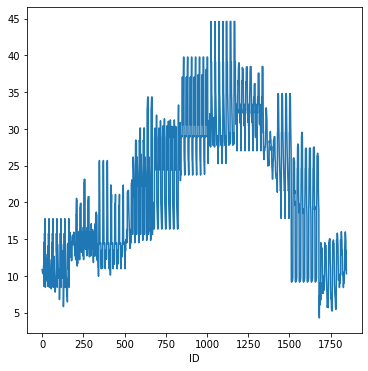

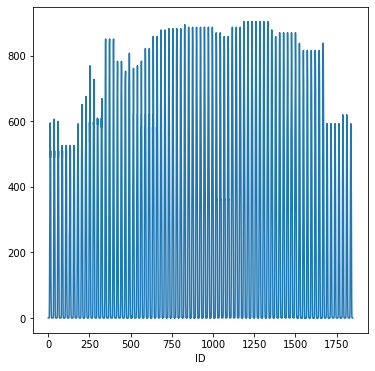

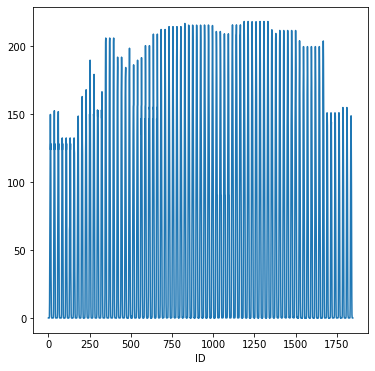

In [315]:
plt.figure(figsize=(6,6))
sample['Temperature(C)'].plot()
plt.figure(figsize=(6,6))
sample['Solar Radiance(w/m^2)'].plot()
plt.figure(figsize=(6,6))
sample['Solar Power(kW)'].plot()